<a href="https://colab.research.google.com/github/rakesh4real/one-or-few-shot-learning/blob/main/ant_classification_with_siamese_triplets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%%capture out

!unzip /content/antenna_classification.zip

!mv /content/antenna_classification/good/front/* /content/antenna_classification/good/
!mv /content/antenna_classification/good/side/* /content/antenna_classification/good/
!rm -r /content/antenna_classification/good/side /content/antenna_classification/good/front

!rm -rf /content/antenna_classification/good/.DS_Store
!rm -rf /content/antenna_classification/bad/.DS_Store
!rm -rf /content/antenna_classification/.DS_Store

In [7]:
# out.show()

In [14]:
import os, cv2
import numpy as np
from pathlib import Path
from PIL import Image

import torch
from torchvision import transforms

def reshape(np_im : np.ndarray, to_dim: tuple, interpolation=cv2.INTER_AREA):
    assert len(to_dim) == 2, "`to_dim` must be a 2-D tuple"
    return cv2.resize(
        np_im, to_dim, interpolation=interpolation)


def read_rgb(im_path):
    ret = cv2.cvtColor(
        cv2.imread(im_path), 
        cv2.COLOR_BGR2RGB)
    if ret is None: raise(f"{im_path} does not exist!")
    return ret


def make_square(
        np_img: np.ndarray, 
        min_size: int = 64, 
        fill_rgba: tuple=(0, 0, 0, 0)):
    
    pil_im = Image.fromarray(np.uint8(np_img)).convert('RGB')
    x, y = pil_im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_rgba)
    new_im.paste(pil_im, (int((size - x) / 2), int((size - y) / 2)))
    return np.array(new_im)


def whc_to_cwh(np_whc_im: np.ndarray):
    return np.transpose(np_whc_im, (2,0,1))

def cwh_to_whc(np_cwh_im: np.ndarray):
    return np.transpose(np_cwh_im, (1,2,0))


def dir_to_np_data(
        data_dir_path: str, 
        min_dim: int = 64, 
        max_dim: int = 64):

    np_data_ncwh = []
    np_labels = []
    DATA_DIR = Path(data_dir_path)

    label_id = -1
    for class_dir in os.listdir(str(DATA_DIR)):
        
        CLASS_DIR = DATA_DIR / class_dir
        label_id += 1

        for im_name in os.listdir(str( CLASS_DIR )):
            
            np_img = read_rgb(str( CLASS_DIR / im_name ))
            padded_sq_im = make_square(np_img, min_size=min_dim)
            padded_sq_im = reshape(padded_sq_im, to_dim=(max_dim, max_dim))
            padded_sq_im = whc_to_cwh(padded_sq_im)

            np_labels.append(label_id)
            np_data_ncwh.append(padded_sq_im)

    np_data_ncwh = np.expand_dims(np_data_ncwh, 0)
    return np.concatenate(np_data_ncwh, axis=1), np.array(np_labels)

In [15]:
xs, ys = dir_to_np_data(
    data_dir_path="/content/antenna_classification",
    max_dim=28) # todo: flexible

xs.shape, ys.shape

((68, 3, 28, 28), (68,))

In [16]:
from sklearn.model_selection import KFold,StratifiedKFold

def get_balnaced_idxs(xs, ys, shuffle=True):
    skf = StratifiedKFold(n_splits=2, shuffle=shuffle)
    for train_idxs, test_idxs in skf.split(xs, ys):
        #print("TRAIN:", train_idxs)
        #print("TEST:", test_idxs)
        # min support for `n_splits` is `2` so break after first
        return (train_idxs, test_idxs)


bal_train_indices, bal_test_indices = get_balnaced_idxs(xs, ys, shuffle=True)

In [17]:
print(bal_train_indices)
print(bal_test_indices)

[ 2  3  5  7  8 10 11 13 14 18 19 20 21 23 25 27 28 29 36 39 40 41 43 45
 49 50 51 55 59 60 61 63 66 67]
[ 0  1  4  6  9 12 15 16 17 22 24 26 30 31 32 33 34 35 37 38 42 44 46 47
 48 52 53 54 56 57 58 62 64 65]


In [48]:
from typing import Tuple, Any
import torch

def torch_cwh_to_whc(arr: torch.Tensor):
    return arr.permute(1,2,0)

class PytorchClassificationDatasetFromNumpy:

    def __init__(self,
                 xs: np.ndarray, 
                 ys: np.ndarray,
                 is_train: bool = False,
                 transforms: transforms.Compose = None):
        """
        :params xs: of shape (n_samples, w, h, c)
        :params ys: of shape (n_samples,)
        """

        self.train = is_train
        self.labels =  ys
        self.data = xs
        self.transform = transforms
        self.is_colored = False
    
    def __len__(self):
        return len(self.labels)


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.labels[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(torch_cwh_to_whc(img).numpy())#, mode='P')

        if self.transform is not None:
            img = self.transform(img)

        # if self.target_transform is not None:
        #     target = self.target_transform(target)

        return img, target


    @property
    def labels(self):
        return self.train_labels if self.train else self.test_labels

    @labels.setter
    def labels(self, ys: np.ndarray):
        torch_ys = torch.from_numpy(ys)
        if self.train:
            self.train_labels = torch_ys
        else:
            self.test_labels = torch_ys


    @property
    def data(self):
        return self.train_data if self.train else self.test_data

    @data.setter
    def data(self, xs: np.ndarray):
        torch_xs = torch.from_numpy(xs)
        if self.train:
            self.train_data = torch_xs
        else:
            self.test_data = torch_xs


    @property
    def transform(self):
        return self._transforms

    @transform.setter
    def transform(self, transforms_composition):
        self._transforms = transforms_composition

In [49]:
from torchvision import transforms

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

transforms_composition = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ])

In [50]:
train_dataset = PytorchClassificationDatasetFromNumpy(
    xs=xs[bal_train_indices],
    ys=ys[bal_train_indices],
    is_train=True,
    transforms=transforms_composition,
)

In [51]:
print(train_dataset.train)
print(train_dataset.transform)

x = train_dataset.train_labels
print(x.shape, type(x))

x = train_dataset.train_data
print(x.shape, type(x))

True
Compose(
    ToTensor()
    Normalize(mean=(0.2860405969887955,), std=(0.35302424451492237,))
)
torch.Size([34]) <class 'torch.Tensor'>
torch.Size([34, 3, 28, 28]) <class 'torch.Tensor'>


In [52]:
test_dataset = PytorchClassificationDatasetFromNumpy(
    xs=xs[bal_test_indices],
    ys=ys[bal_test_indices],
    is_train=False,
    transforms=transforms_composition,
)

In [53]:
print(test_dataset.train)
print(test_dataset.transform)

x = test_dataset.test_labels
print(x.shape, type(x))

x = test_dataset.test_data
print(x.shape, type(x))

False
Compose(
    ToTensor()
    Normalize(mean=(0.2860405969887955,), std=(0.35302424451492237,))
)
torch.Size([34]) <class 'torch.Tensor'>
torch.Size([34, 3, 28, 28]) <class 'torch.Tensor'>


In [54]:
import numpy as np
from PIL import Image

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler


class SiameseMNIST(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        #img1 = Image.fromarray(img1.numpy(), mode='L')
        #img2 = Image.fromarray(img2.numpy(), mode='L')
        #img2 = Image.fromarray(img2.numpy())#, mode='P')
        #img1 = Image.fromarray(img1.numpy())#, mode='P')
        img2 = Image.fromarray(cwh_to_whc(img2.numpy()))#, mode='P')
        img1 = Image.fromarray(cwh_to_whc(img1.numpy()))#, mode='P')
        

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset)

In [55]:
train_dset = SiameseMNIST(train_dataset)

train_dset.labels_set

{0, 1}

In [56]:
SiameseMNIST(test_dataset)

In [57]:
"""
deps
"""

'\ndeps\n'

In [58]:
"""
losses
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


class OnlineContrastiveLoss(nn.Module):
    """
    Online Contrastive loss
    Takes a batch of embeddings and corresponding labels.
    Pairs are generated using pair_selector object that take embeddings and targets and return indices of positive
    and negative pairs
    """

    def __init__(self, margin, pair_selector):
        super(OnlineContrastiveLoss, self).__init__()
        self.margin = margin
        self.pair_selector = pair_selector

    def forward(self, embeddings, target):
        positive_pairs, negative_pairs = self.pair_selector.get_pairs(embeddings, target)
        if embeddings.is_cuda:
            positive_pairs = positive_pairs.cuda()
            negative_pairs = negative_pairs.cuda()
        positive_loss = (embeddings[positive_pairs[:, 0]] - embeddings[positive_pairs[:, 1]]).pow(2).sum(1)
        negative_loss = F.relu(
            self.margin - (embeddings[negative_pairs[:, 0]] - embeddings[negative_pairs[:, 1]]).pow(2).sum(
                1).sqrt()).pow(2)
        loss = torch.cat([positive_loss, negative_loss], dim=0)
        return loss.mean()


class OnlineTripletLoss(nn.Module):
    """
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        ap_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 1]]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 2]]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean(), len(triplets)

In [71]:
"""
trainer -> fit
"""

import torch
import numpy as np


def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model
    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        # must be after `optimizer.step()`
        # scheduler.step()

        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)


def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()

        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics


def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

In [104]:
"""
networks
"""

import torch.nn as nn
import torch.nn.functional as F


class EmbeddingNet(nn.Module):
    def __init__(self, n_ch=1):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(n_ch, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)


class EmbeddingNetL2(EmbeddingNet):
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(self, x):
        output = super(EmbeddingNetL2, self).forward(x)
        output /= output.pow(2).sum(1, keepdim=True).sqrt()
        return output

    def get_embedding(self, x):
        return self.forward(x)


class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))


class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)


class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [73]:
cuda = torch.cuda.is_available()

In [74]:
# Step 1
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 4
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [80]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

#from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt



# Step 2
embedding_net = EmbeddingNet(n_ch=3)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 500

In [81]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/34 (0%)]	Loss: 0.121572
Epoch: 1/50. Train set: Average loss: 0.1908
Epoch: 1/50. Validation set: Average loss: 0.1089
Train: [0/34 (0%)]	Loss: 0.047921
Epoch: 2/50. Train set: Average loss: 0.1212
Epoch: 2/50. Validation set: Average loss: 0.2043
Train: [0/34 (0%)]	Loss: 0.212304
Epoch: 3/50. Train set: Average loss: 0.1702
Epoch: 3/50. Validation set: Average loss: 0.1297
Train: [0/34 (0%)]	Loss: 0.126910
Epoch: 4/50. Train set: Average loss: 0.1566
Epoch: 4/50. Validation set: Average loss: 0.1356
Train: [0/34 (0%)]	Loss: 0.127302
Epoch: 5/50. Train set: Average loss: 0.0947
Epoch: 5/50. Validation set: Average loss: 0.0737
Train: [0/34 (0%)]	Loss: 0.065226
Epoch: 6/50. Train set: Average loss: 0.0880
Epoch: 6/50. Validation set: Average loss: 0.1096
Train: [0/34 (0%)]	Loss: 0.084423
Epoch: 7/50. Train set: Average loss: 0.0644
Epoch: 7/50. Validation set: Average loss: 0.0661
Train: [0/34 (0%)]	Loss: 0.001142
Epoch: 8/50. Train set: Average loss: 0.0748
Epoch: 8/50. Valid

In [82]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

#from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


class_names_by_idx = ['Good Antennas', 'Bad Antenna']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

mnist_classes = class_names_by_idx

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            #print(images.shape)
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [83]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

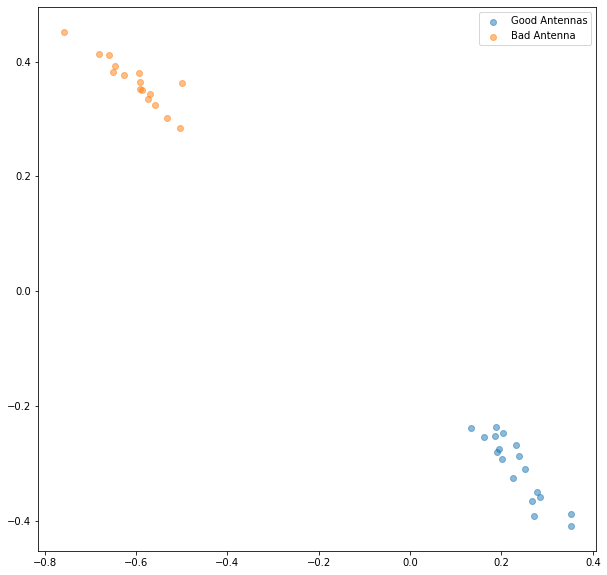

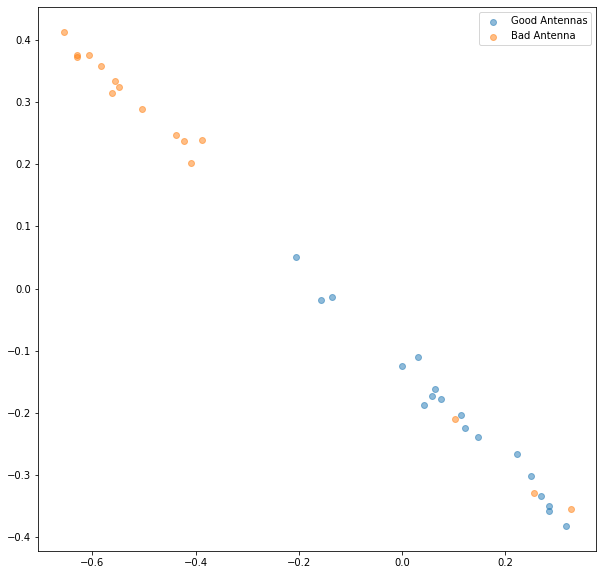

In [84]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

In [88]:
""""
triplet loss
"""

None

In [89]:
"""
losses
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


class OnlineContrastiveLoss(nn.Module):
    """
    Online Contrastive loss
    Takes a batch of embeddings and corresponding labels.
    Pairs are generated using pair_selector object that take embeddings and targets and return indices of positive
    and negative pairs
    """

    def __init__(self, margin, pair_selector):
        super(OnlineContrastiveLoss, self).__init__()
        self.margin = margin
        self.pair_selector = pair_selector

    def forward(self, embeddings, target):
        positive_pairs, negative_pairs = self.pair_selector.get_pairs(embeddings, target)
        if embeddings.is_cuda:
            positive_pairs = positive_pairs.cuda()
            negative_pairs = negative_pairs.cuda()
        positive_loss = (embeddings[positive_pairs[:, 0]] - embeddings[positive_pairs[:, 1]]).pow(2).sum(1)
        negative_loss = F.relu(
            self.margin - (embeddings[negative_pairs[:, 0]] - embeddings[negative_pairs[:, 1]]).pow(2).sum(
                1).sqrt()).pow(2)
        loss = torch.cat([positive_loss, negative_loss], dim=0)
        return loss.mean()


class OnlineTripletLoss(nn.Module):
    """
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        ap_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 1]]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 2]]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean(), len(triplets)

In [96]:
class TripletMNIST(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            triplets = [[i,
                         random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                         random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels[i].item()]))
                                                 )
                                             ])
                         ]
                        for i in range(len(self.test_data))]
            self.test_triplets = triplets

    def __getitem__(self, index):
        if self.train:
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data[positive_index]
            img3 = self.train_data[negative_index]
        else:
            img1 = self.test_data[self.test_triplets[index][0]]
            img2 = self.test_data[self.test_triplets[index][1]]
            img3 = self.test_data[self.test_triplets[index][2]]

        #img1 = Image.fromarray(img1.numpy())#, mode='L')
        #img2 = Image.fromarray(img2.numpy())#, mode='L')
        #img3 = Image.fromarray(img3.numpy())#, mode='L')
        
        cwh_to_whc
        img1 = Image.fromarray(cwh_to_whc(img1.numpy()))#, mode='L')
        img2 = Image.fromarray(cwh_to_whc(img2.numpy()))#, mode='L')
        img3 = Image.fromarray(cwh_to_whc(img3.numpy()))#, mode='L')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)
        return (img1, img2, img3), []

    def __len__(self):
        return len(self.mnist_dataset)

In [130]:
# Set up data loaders
# from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 4
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
# from networks import EmbeddingNet, TripletNet
# from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet(n_ch=3)
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

In [131]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/34 (0%)]	Loss: 0.999751
Epoch: 1/20. Train set: Average loss: 1.0300
Epoch: 1/20. Validation set: Average loss: 0.9911
Train: [0/34 (0%)]	Loss: 0.717471
Epoch: 2/20. Train set: Average loss: 0.7893
Epoch: 2/20. Validation set: Average loss: 0.8707
Train: [0/34 (0%)]	Loss: 0.612752
Epoch: 3/20. Train set: Average loss: 0.5028
Epoch: 3/20. Validation set: Average loss: 0.9877
Train: [0/34 (0%)]	Loss: 0.367668
Epoch: 4/20. Train set: Average loss: 0.2829
Epoch: 4/20. Validation set: Average loss: 0.8035
Train: [0/34 (0%)]	Loss: 0.177287
Epoch: 5/20. Train set: Average loss: 0.1517
Epoch: 5/20. Validation set: Average loss: 1.7390
Train: [0/34 (0%)]	Loss: 0.000000
Epoch: 6/20. Train set: Average loss: 0.8112
Epoch: 6/20. Validation set: Average loss: 0.6068
Train: [0/34 (0%)]	Loss: 0.060317
Epoch: 7/20. Train set: Average loss: 0.2208
Epoch: 7/20. Validation set: Average loss: 0.7210
Train: [0/34 (0%)]	Loss: 0.000000
Epoch: 8/20. Train set: Average loss: 0.2560
Epoch: 8/20. Valid

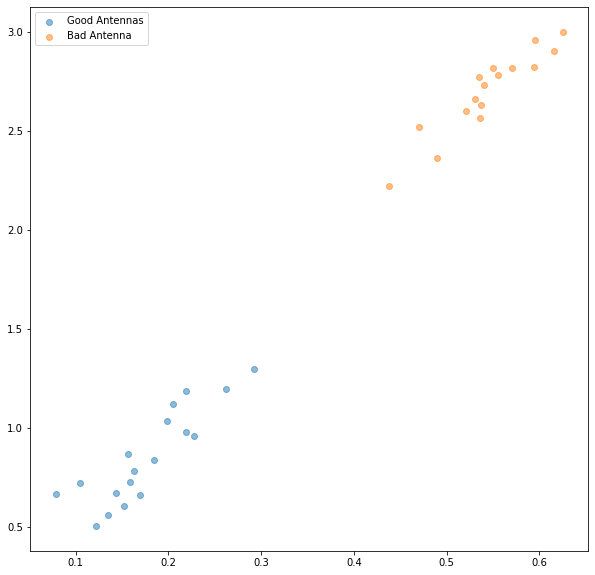

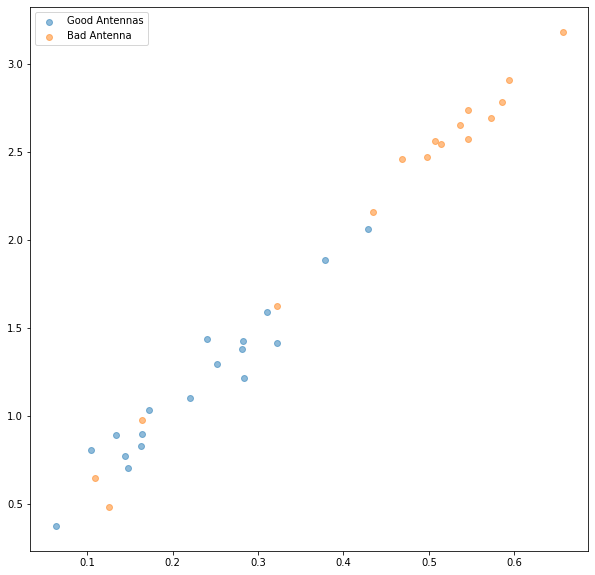

In [132]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)

val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

In [108]:
"""
online pair selection
"""

class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [109]:
from itertools import combinations

import numpy as np
import torch


def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix


class PairSelector:
    """
    Implementation should return indices of positive pairs and negative pairs that will be passed to compute
    Contrastive Loss
    return positive_pairs, negative_pairs
    """

    def __init__(self):
        pass

    def get_pairs(self, embeddings, labels):
        raise NotImplementedError


class AllPositivePairSelector(PairSelector):
    """
    Discards embeddings and generates all possible pairs given labels.
    If balance is True, negative pairs are a random sample to match the number of positive samples
    """
    def __init__(self, balance=True):
        super(AllPositivePairSelector, self).__init__()
        self.balance = balance

    def get_pairs(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]
        if self.balance:
            negative_pairs = negative_pairs[torch.randperm(len(negative_pairs))[:len(positive_pairs)]]

        return positive_pairs, negative_pairs


class HardNegativePairSelector(PairSelector):
    """
    Creates all possible positive pairs. For negative pairs, pairs with smallest distance are taken into consideration,
    matching the number of positive pairs.
    """

    def __init__(self, cpu=True):
        super(HardNegativePairSelector, self).__init__()
        self.cpu = cpu

    def get_pairs(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)

        labels = labels.cpu().data.numpy()
        all_pairs = np.array(list(combinations(range(len(labels)), 2)))
        all_pairs = torch.LongTensor(all_pairs)
        positive_pairs = all_pairs[(labels[all_pairs[:, 0]] == labels[all_pairs[:, 1]]).nonzero()]
        negative_pairs = all_pairs[(labels[all_pairs[:, 0]] != labels[all_pairs[:, 1]]).nonzero()]

        negative_distances = distance_matrix[negative_pairs[:, 0], negative_pairs[:, 1]]
        negative_distances = negative_distances.cpu().data.numpy()
        top_negatives = np.argpartition(negative_distances, len(positive_pairs))[:len(positive_pairs)]
        top_negative_pairs = negative_pairs[torch.LongTensor(top_negatives)]

        return positive_pairs, top_negative_pairs


class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError


class AllTripletSelector(TripletSelector):
    """
    Returns all possible triplets
    May be impractical in most cases
    """

    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None


def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None


class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)


def HardestNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                 negative_selection_fn=hardest_negative,
                                                                                 cpu=cpu)


def RandomNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                negative_selection_fn=random_hard_negative,
                                                                                cpu=cpu)


def SemihardNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                  negative_selection_fn=lambda x: semihard_negative(x, margin),
                                                                                  cpu=cpu)

In [124]:

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=2, n_samples=8)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=2, n_samples=8)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
#from networks import EmbeddingNet
#from losses import OnlineContrastiveLoss
#from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet(n_ch=3)
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 250

In [125]:
all_embeddings = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/34 (0%)]	Loss: 0.488540
Epoch: 1/50. Train set: Average loss: 0.4386
Epoch: 1/50. Validation set: Average loss: 0.3897
Train: [0/34 (0%)]	Loss: 0.385290
Epoch: 2/50. Train set: Average loss: 0.3636
Epoch: 2/50. Validation set: Average loss: 0.3353
Train: [0/34 (0%)]	Loss: 0.322447
Epoch: 3/50. Train set: Average loss: 0.3312
Epoch: 3/50. Validation set: Average loss: 0.3087
Train: [0/34 (0%)]	Loss: 0.310371
Epoch: 4/50. Train set: Average loss: 0.2883
Epoch: 4/50. Validation set: Average loss: 0.3158
Train: [0/34 (0%)]	Loss: 0.280436
Epoch: 5/50. Train set: Average loss: 0.2490
Epoch: 5/50. Validation set: Average loss: 0.2839
Train: [0/34 (0%)]	Loss: 0.157697
Epoch: 6/50. Train set: Average loss: 0.2075
Epoch: 6/50. Validation set: Average loss: 0.2915
Train: [0/34 (0%)]	Loss: 0.146610
Epoch: 7/50. Train set: Average loss: 0.1553
Epoch: 7/50. Validation set: Average loss: 0.2910
Train: [0/34 (0%)]	Loss: 0.120780
Epoch: 8/50. Train set: Average loss: 0.1053
Epoch: 8/50. Valid

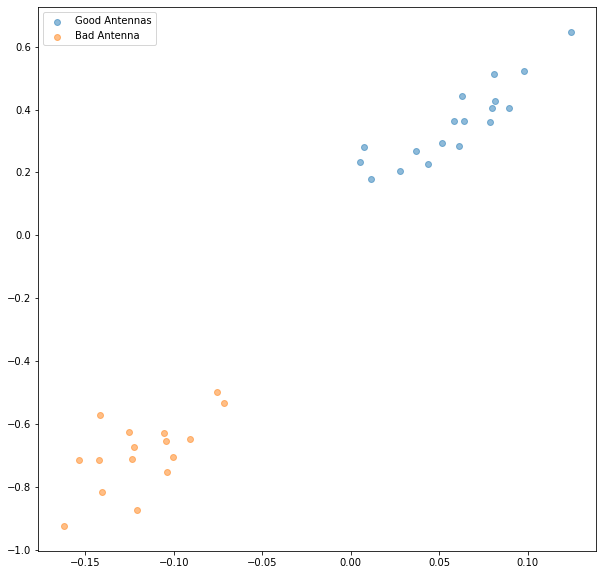

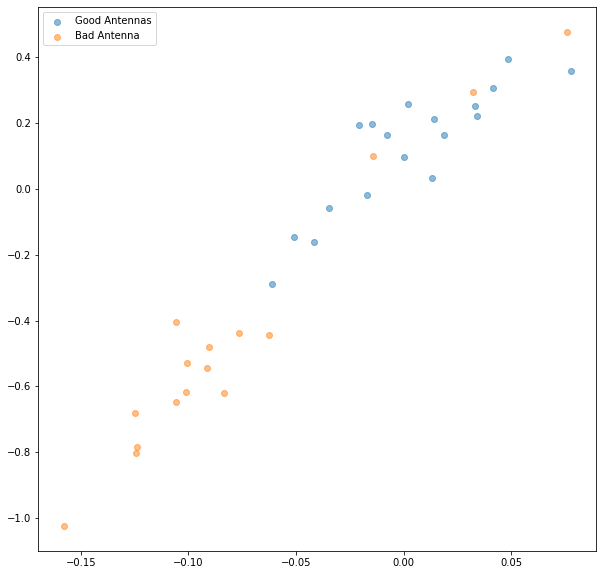

In [126]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)

val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)